In [355]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
import scipy
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns


In [356]:
# dir for mac

sst_file_dir = "/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/northeast_sst.nc"
prec_file_dir = "/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/precipitation_north_east_au.nc"

In [357]:
sst_oisst = xr.open_dataarray(sst_file_dir)

sst_oisst = sst_oisst.loc[0: 8034,:, :]

precip = xr.open_dataarray(prec_file_dir)

In [358]:
sst_oisst

<xarray.DataArray 'sst' (time: 8034, lat: 82, lon: 82)>
[54020616 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -30.12 -29.88 -29.62 -29.38 ... -10.38 -10.12 -9.875
  * lon      (lon) float64 139.9 140.1 140.4 140.6 ... 159.4 159.6 159.9 160.1
  * time     (time) float64 1.0 2.0 3.0 4.0 ... 8.032e+03 8.033e+03 8.034e+03

In [359]:
date_time = pd.date_range(start='1998-01-01', periods=8034, freq='D')



In [360]:
sst_oisst['time'] = date_time

precip['time'] = date_time

In [361]:
precip_box_01 = precip.sel(lat=slice(-18,-15), lon=slice(146,149))

precip_box_01_rain = np.where(precip_box_01 > 0.01, precip_box_01, np.nan)


sst_oisst_box_01 = sst_oisst.sel(lat=slice(-18,-15), lon=slice(146,149))

In [362]:
precip_box_01_values = precip_box_01.values.reshape(8034*12*12)

precip_box_01_values_log = np.log1p(precip_box_01_values)

sst_oisst_box_01_values = sst_oisst_box_01.values.reshape(8034*12*12)

precip_box_01_values_rain = precip_box_01_rain.reshape(8034*12*12)

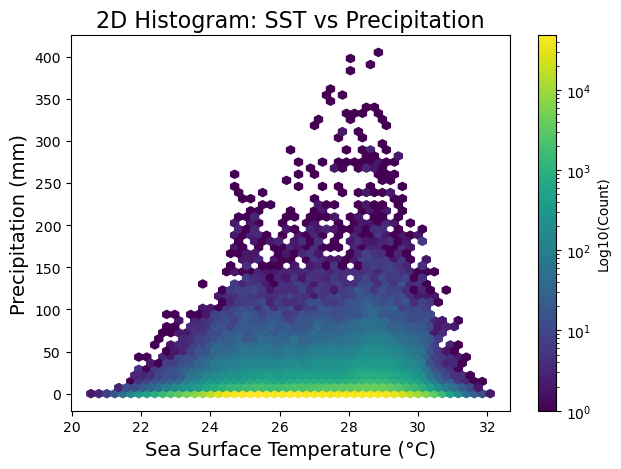

In [363]:
plt.Figure(figsize=(12, 8))

hb = plt.hexbin(sst_oisst_box_01_values, precip_box_01_values, gridsize=50, cmap='viridis', bins='log')

plt.colorbar(hb, label='Log10(Count)')
plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
plt.ylabel('Precipitation (mm)', fontsize=14)
plt.title('2D Histogram: SST vs Precipitation', fontsize=16)

plt.tight_layout()
plt.show()

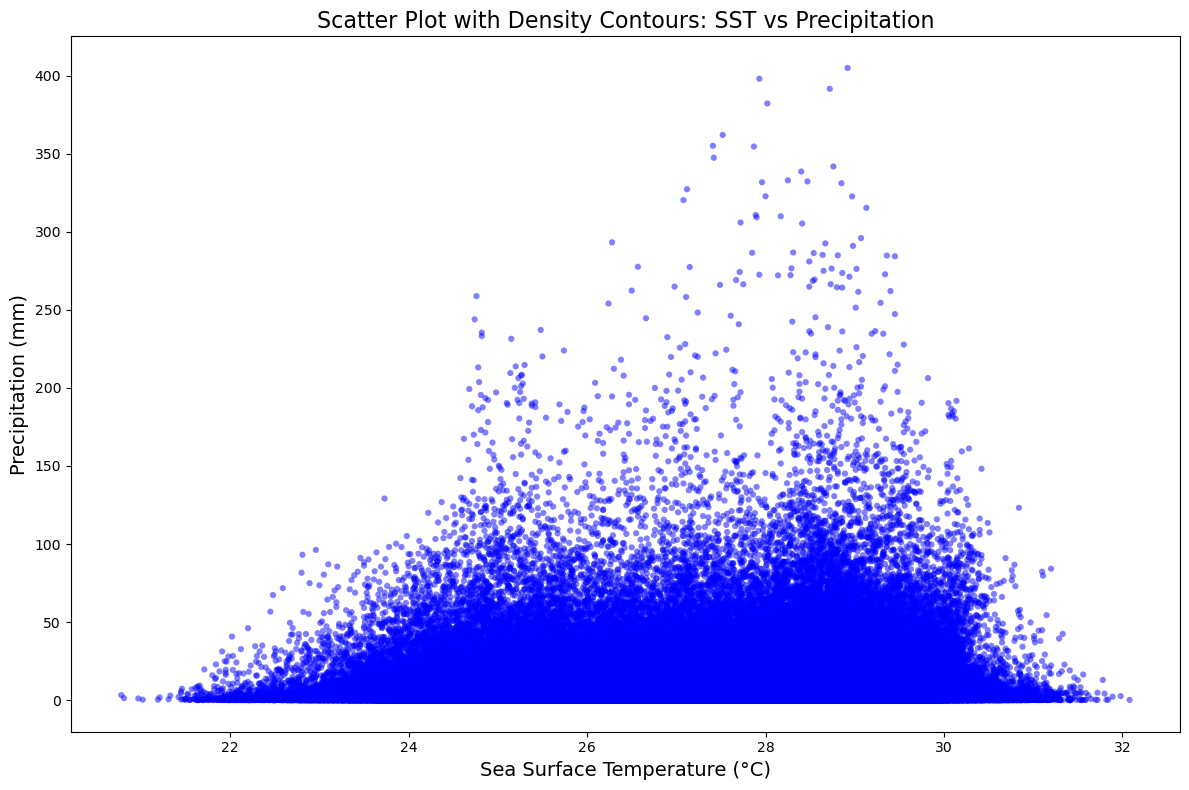

In [364]:
plt.figure(figsize=(12, 8))

plt.scatter(sst_oisst_box_01, precip_box_01_values_rain, 
            alpha=0.5,  # Transparency 
            s=20,       # Marker size
            c='blue',   # Color
            edgecolors='none')

# Add KDE contours to visualize density


plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
plt.ylabel('Precipitation (mm)', fontsize=14)
plt.title('Scatter Plot with Density Contours: SST vs Precipitation', fontsize=16)

plt.tight_layout()
plt.show()

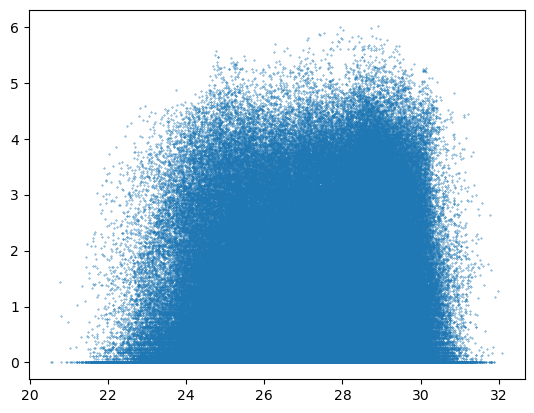

In [365]:
plt.scatter(sst_oisst_box_01_values, precip_box_01_values_log, s=0.1)

## Precipitation Accumulation

In [366]:
data = pd.DataFrame({'SST': sst_oisst_box_01_values, 'Precipitation': precip_box_01_values})

sst_bins = np.arange(22, 32, 1)
bin_labels = [f'({bin_edge:.1f}, {bin_edge+1:.1f})' for bin_edge in sst_bins[:-1]]


data['SST_bin'] = pd.cut(data['SST'], bins=sst_bins,right = False, labels=bin_labels)

accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()
accumulated_precip['bin_midpoint'] = [bin_edge + 0.5 for bin_edge in range(22, 31)]
print("Accumulated Precipitation by SST Bin:")
print(accumulated_precip)


Accumulated Precipitation by SST Bin:
        SST_bin  Precipitation  bin_midpoint
0  (22.0, 23.0)    7664.219825          22.5
1  (23.0, 24.0)   53059.168739          23.5
2  (24.0, 25.0)  200863.315021          24.5
3  (25.0, 26.0)  310315.192756          25.5
4  (26.0, 27.0)  357901.671607          26.5
5  (27.0, 28.0)  454932.589747          27.5
6  (28.0, 29.0)  699198.883116          28.5
7  (29.0, 30.0)  461889.049350          29.5
8  (30.0, 31.0)   74133.388352          30.5


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_48768/784197594.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()


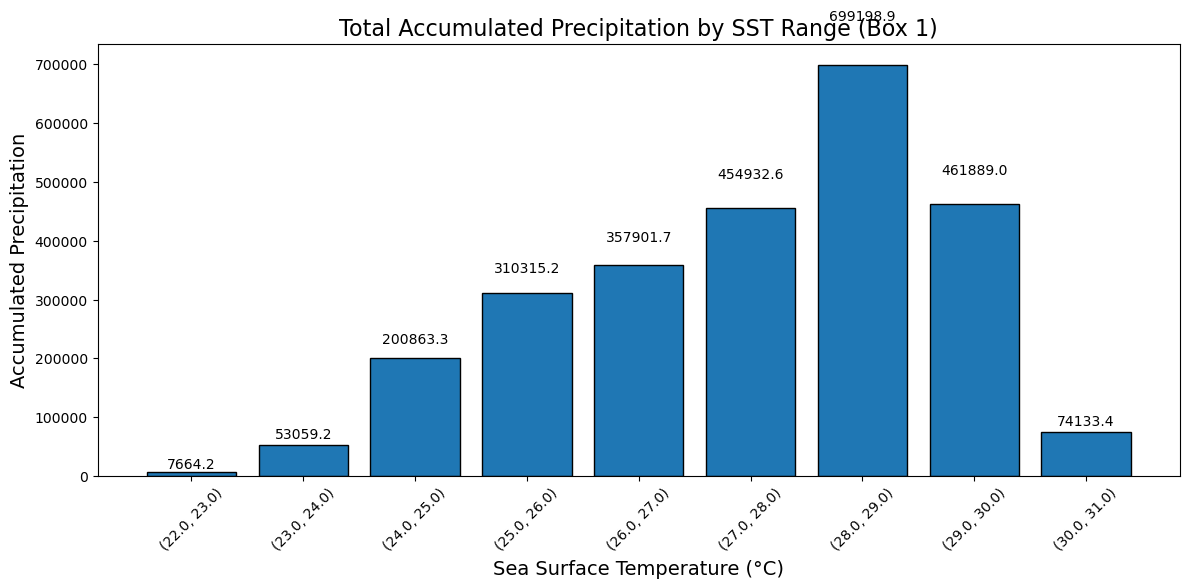

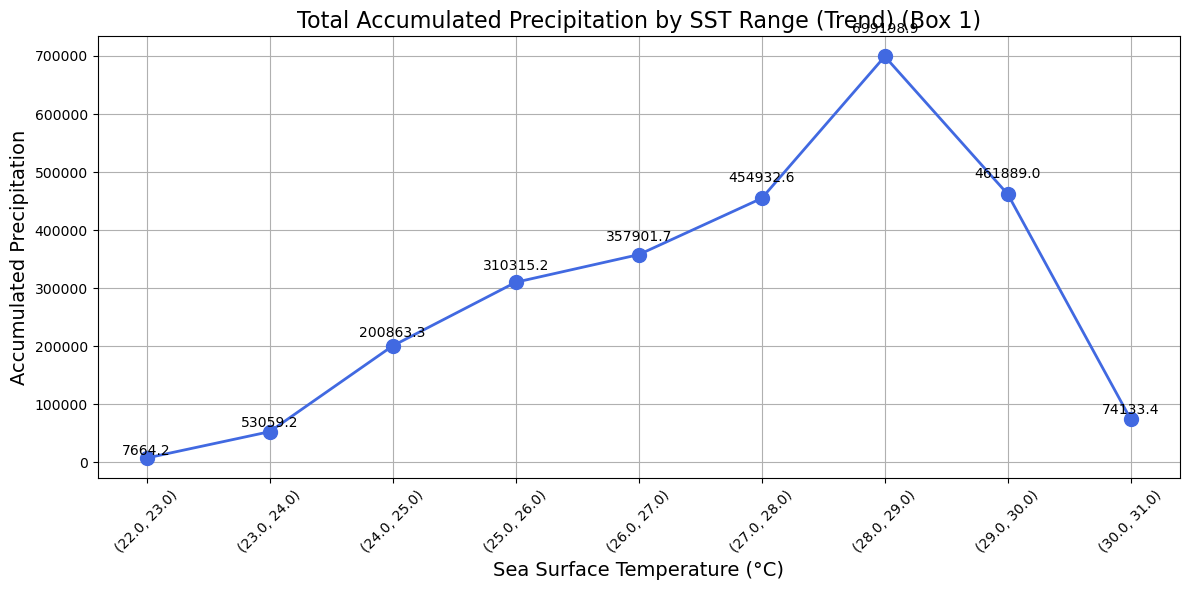

/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_48768/4082417498.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([



Detailed Statistics for Each SST Bin:
        SST_bin            sum      mean   count         max        std
0  (22.0, 23.0)    7664.219825  1.358423    5642   96.209999   5.288371
1  (23.0, 24.0)   53059.168739  1.537724   34505  129.149994   6.263846
2  (24.0, 25.0)  200863.315021  1.298657  154670  258.779968   6.929213
3  (25.0, 26.0)  310315.192756  1.495538  207494  237.089996   7.498654
4  (26.0, 27.0)  357901.671607  1.734810  206306  293.190002   7.844716
5  (27.0, 28.0)  454932.589747  2.359364  192820  397.980011   9.585204
6  (28.0, 29.0)  699198.883116  3.349568  208743  404.879974  11.848577
7  (29.0, 30.0)  461889.049350  3.653636  126419  315.269989  11.922973
8  (30.0, 31.0)   74133.388352  3.822885   19392  191.699997  12.618749


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_48768/4082417498.py:39: FutureWarning: The provided callable <function std at 0x106f28040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_48768/4082417498.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bin_stats['SST_bin'], rotation=45)


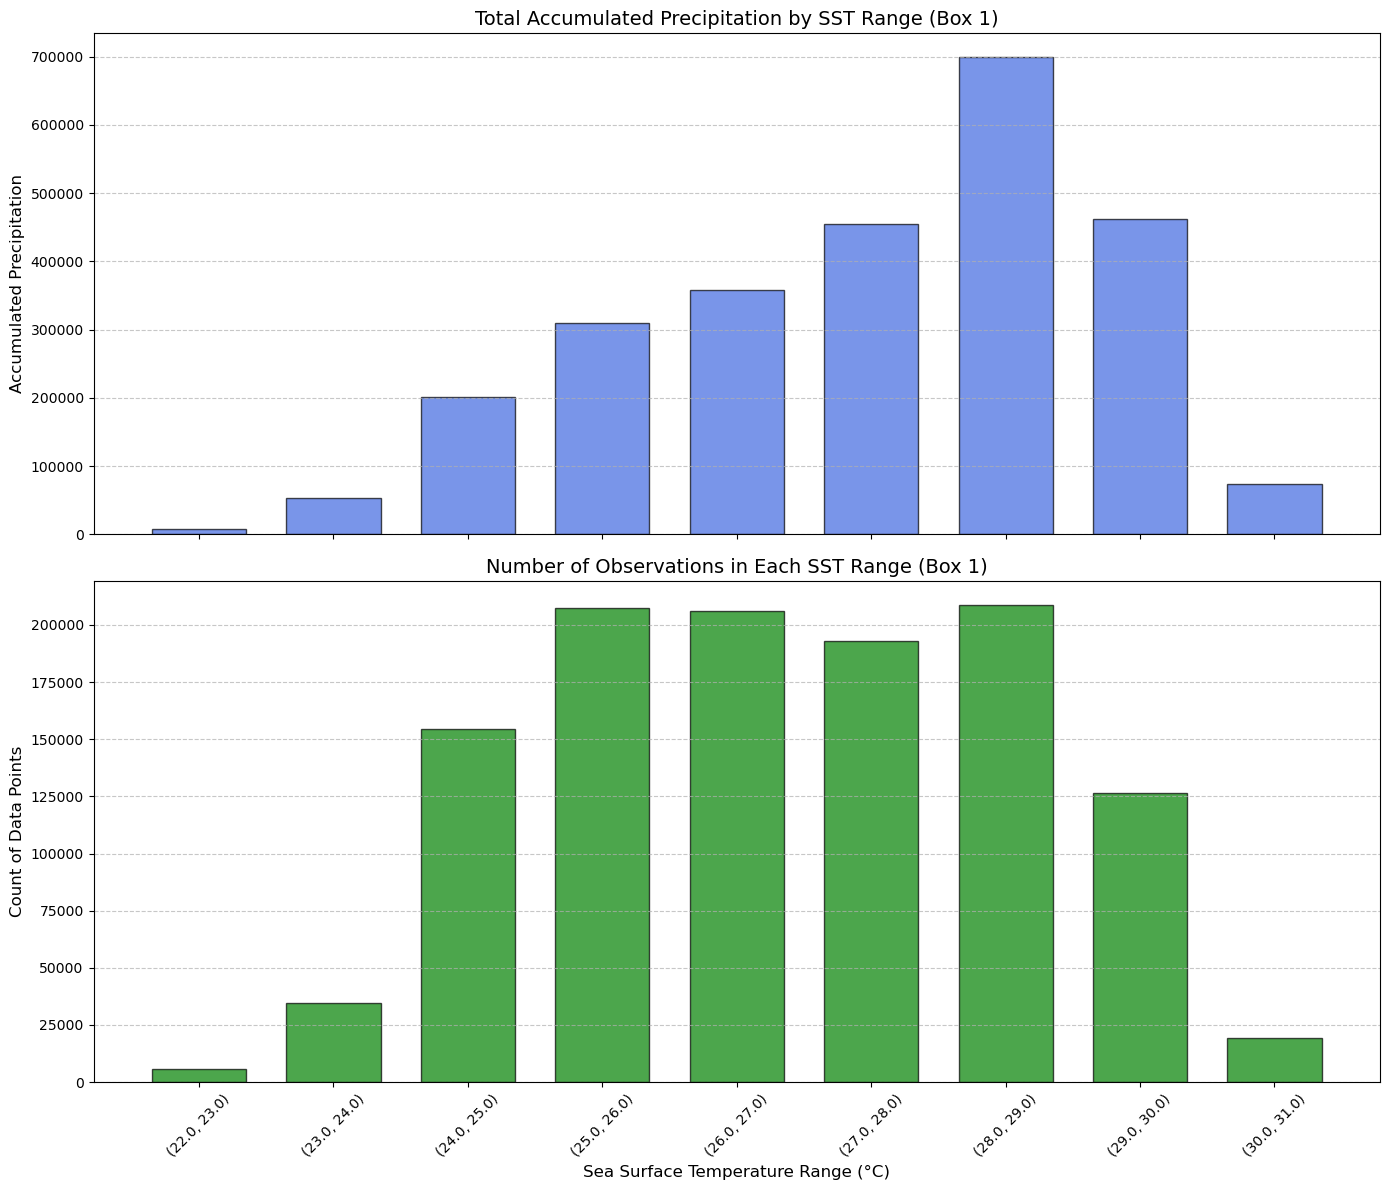

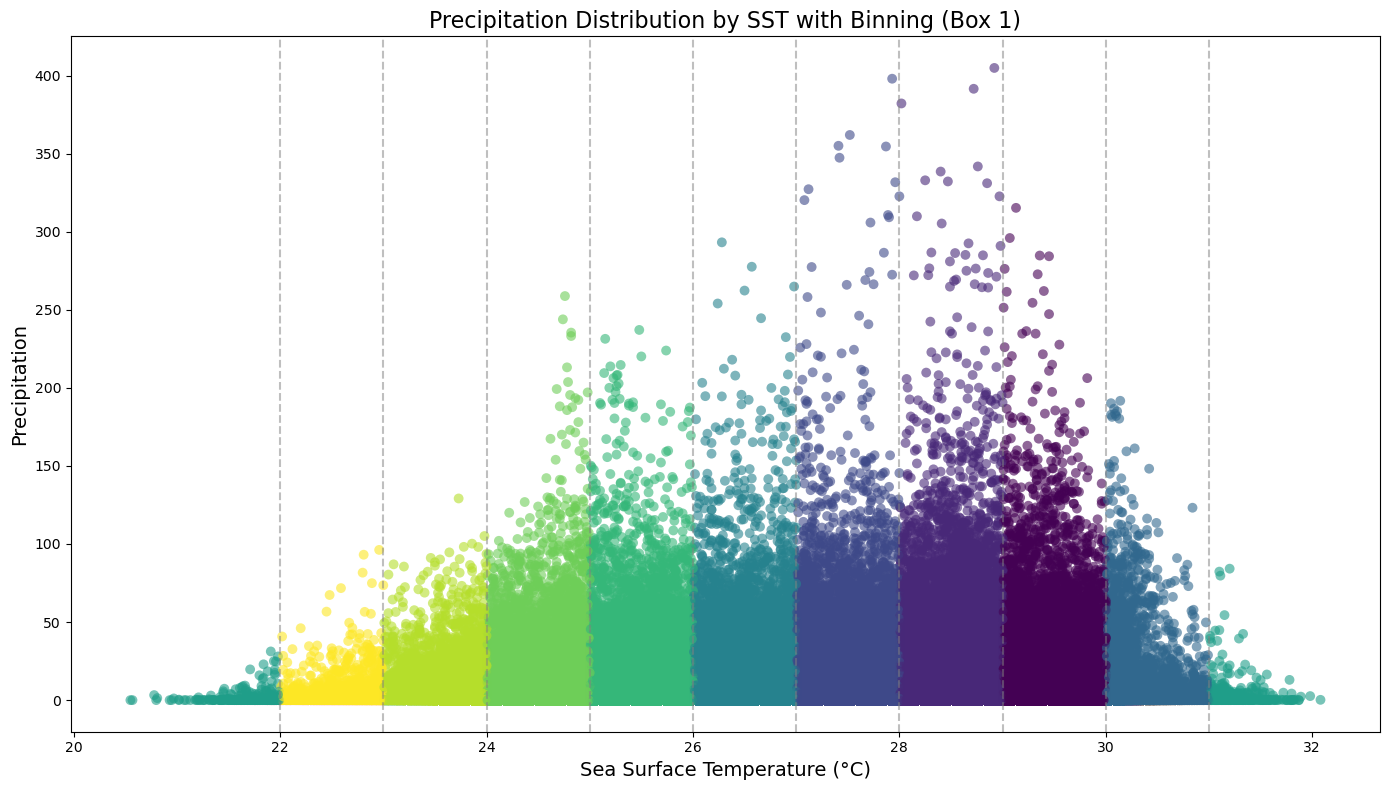

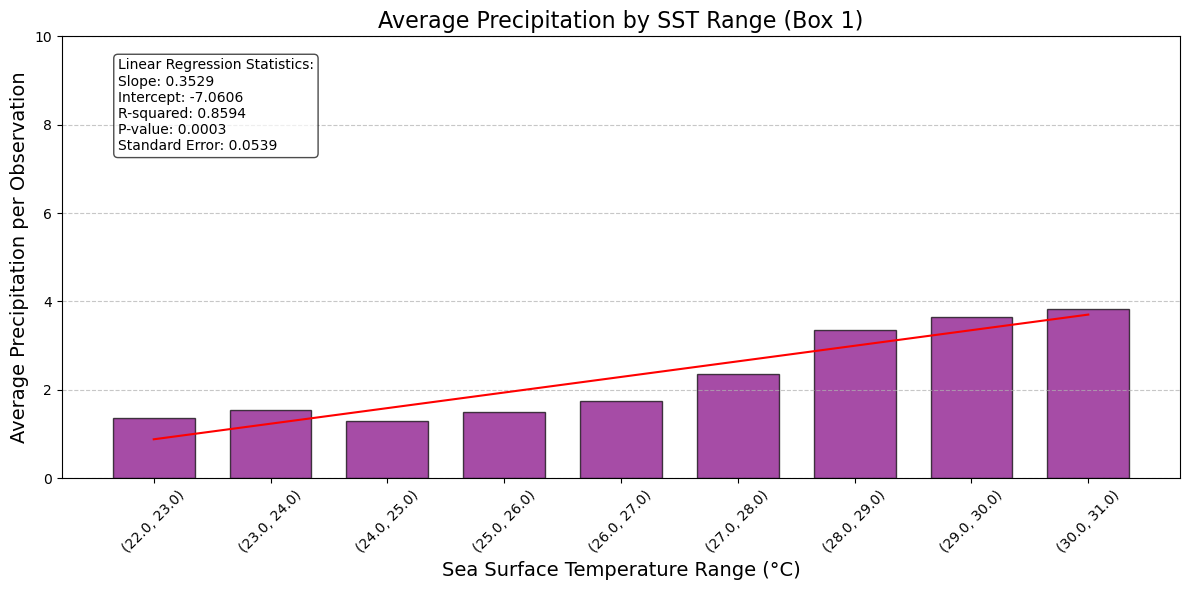

In [367]:
# Create a bar plot of accumulated precipitation vs SST bins
plt.figure(figsize=(12, 6))
bars = plt.bar(accumulated_precip['bin_midpoint'], accumulated_precip['Precipitation'], 
        width=0.8, edgecolor='black', linewidth=1)

# Add data labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1 * height,
            f'{height:.1f}',
            ha='center', va='bottom', rotation=0, fontsize=10)

plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
plt.ylabel('Accumulated Precipitation', fontsize=14)
plt.title('Total Accumulated Precipitation by SST Range (Box 1)', fontsize=16)
plt.xticks(accumulated_precip['bin_midpoint'], bin_labels, rotation=45)
plt.tight_layout()
plt.show()

# Create a line plot to show the trend more clearly
plt.figure(figsize=(12, 6))
plt.plot(accumulated_precip['bin_midpoint'], accumulated_precip['Precipitation'], 
         marker='o', markersize=10, linewidth=2, color='royalblue')

# Add data labels to each point
for i, val in enumerate(accumulated_precip['Precipitation']):
    plt.text(accumulated_precip['bin_midpoint'][i], val + 0.05 * val, 
             f'{val:.1f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
plt.ylabel('Accumulated Precipitation', fontsize=14)
plt.title('Total Accumulated Precipitation by SST Range (Trend) (Box 1)', fontsize=16)
plt.xticks(accumulated_precip['bin_midpoint'], bin_labels, rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Calculate some additional statistics for each bin
bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
    ('sum', 'sum'),              # Total accumulated precipitation
    ('mean', 'mean'),            # Average precipitation per data point in bin
    ('count', 'count'),          # Number of data points in bin
    ('max', 'max'),              # Maximum precipitation in bin
    ('std', np.std)              # Standard deviation of precipitation in bin
]).reset_index()

# Display the detailed statistics
print("\nDetailed Statistics for Each SST Bin:")
print(bin_stats)

# Create a multi-plot figure showing different aspects of the data
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot 1: Accumulated precipitation
axes[0].bar(bin_stats['SST_bin'], bin_stats['sum'], 
          width=0.7, color='royalblue', edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Accumulated Precipitation', fontsize=12)
axes[0].set_title('Total Accumulated Precipitation by SST Range (Box 1)', fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Count of data points in each bin
axes[1].bar(bin_stats['SST_bin'], bin_stats['count'], 
          width=0.7, color='green', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Sea Surface Temperature Range (°C)', fontsize=12)
axes[1].set_ylabel('Count of Data Points', fontsize=12)
axes[1].set_title('Number of Observations in Each SST Range (Box 1)', fontsize=14)
axes[1].set_xticklabels(bin_stats['SST_bin'], rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Create a stacked visualization: Precipitation vs SST with bin coloring
plt.figure(figsize=(14, 8))

# Create a scatter plot with points colored by SST bin
# Convert bin labels to numeric for coloring
unique_bins = data['SST_bin'].unique()
bin_to_number = {bin_label: i for i, bin_label in enumerate(unique_bins)}
data['bin_number'] = data['SST_bin'].map(bin_to_number)

# Scatter plot colored by bin
scatter = plt.scatter(data['SST'], data['Precipitation'], 
                     c=data['bin_number'], cmap='viridis', 
                     alpha=0.6, s=50, edgecolors='none')

# Add vertical lines to show bin boundaries
for bin_edge in sst_bins:
    plt.axvline(x=bin_edge, color='gray', linestyle='--', alpha=0.5)

# Add legend for the bins
legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                    labels=unique_bins,
                    title="SST Bins",
                    loc="upper left",
                    bbox_to_anchor=(1.01, 1))
plt.gca().add_artist(legend1)

plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
plt.ylabel('Precipitation', fontsize=14)
plt.title('Precipitation Distribution by SST with Binning (Box 1)', fontsize=16)
plt.tight_layout()
plt.show()

# Calculate the proportion of total precipitation that falls in each SST bin
total_precip = bin_stats['sum'].sum()
bin_stats['percentage'] = (bin_stats['sum'] / total_precip) * 100


# Normalized precipitation by count (average precipitation per observation in each bin)
plt.figure(figsize=(12, 6))
plt.bar(bin_stats['SST_bin'], bin_stats['mean'], 
       width=0.7, color='purple', edgecolor='black', alpha=0.7)
plt.ylim(0, 10)
plt.xlabel('Sea Surface Temperature Range (°C)', fontsize=14)
plt.ylabel('Average Precipitation per Observation', fontsize=14)
plt.title('Average Precipitation by SST Range (Box 1)', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

slope, intercept, r_value, p_value, std_err = stats.linregress(accumulated_precip['bin_midpoint'], bin_stats['mean'])

regression_line = slope * accumulated_precip['bin_midpoint'] + intercept 
plt.plot(bin_stats['SST_bin'], regression_line, color='red', label='Linear Regression')
stats_text = (f'Linear Regression Statistics:\n'
              f'Slope: {slope:.4f}\n'
              f'Intercept: {intercept:.4f}\n'
              f'R-squared: {r_value**2:.4f}\n'
              f'P-value: {p_value:.4f}\n'
              f'Standard Error: {std_err:.4f}')

plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.show()

## Only include observations which precipitation is greater that 0.01 mm

## Box 2 plot

In [368]:
precip_box_02 = precip.sel(lat=slice(-18,-15), lon=slice(152,155))

precip_box_02_rain = np.where(precip_box_01 > 0.01, precip_box_01, np.nan)


sst_oisst_box_02 = sst_oisst.sel(lat=slice(-18,-15), lon=slice(152,155))

In [369]:
precip_box_02_values = precip_box_02.values.reshape(8034*12*12)

precip_box_02_values_log = np.log1p(precip_box_02_values)

sst_oisst_box_02_values = sst_oisst_box_02.values.reshape(8034*12*12)

precip_box_02_values_rain = precip_box_02_rain.reshape(8034*12*12)

Accumulated Precipitation by SST Bin:
        SST_bin  Precipitation  bin_midpoint
0  (22.0, 23.0)   6.540000e+00          22.5
1  (23.0, 24.0)   6.720840e+03          23.5
2  (24.0, 25.0)   9.540540e+04          24.5
3  (25.0, 26.0)   2.772760e+05          25.5
4  (26.0, 27.0)   4.104313e+05          26.5
5  (27.0, 28.0)   8.517957e+05          27.5
6  (28.0, 29.0)   1.270188e+06          28.5
7  (29.0, 30.0)   7.257851e+05          29.5
8  (30.0, 31.0)   9.816669e+04          30.5


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_48768/1931402131.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()


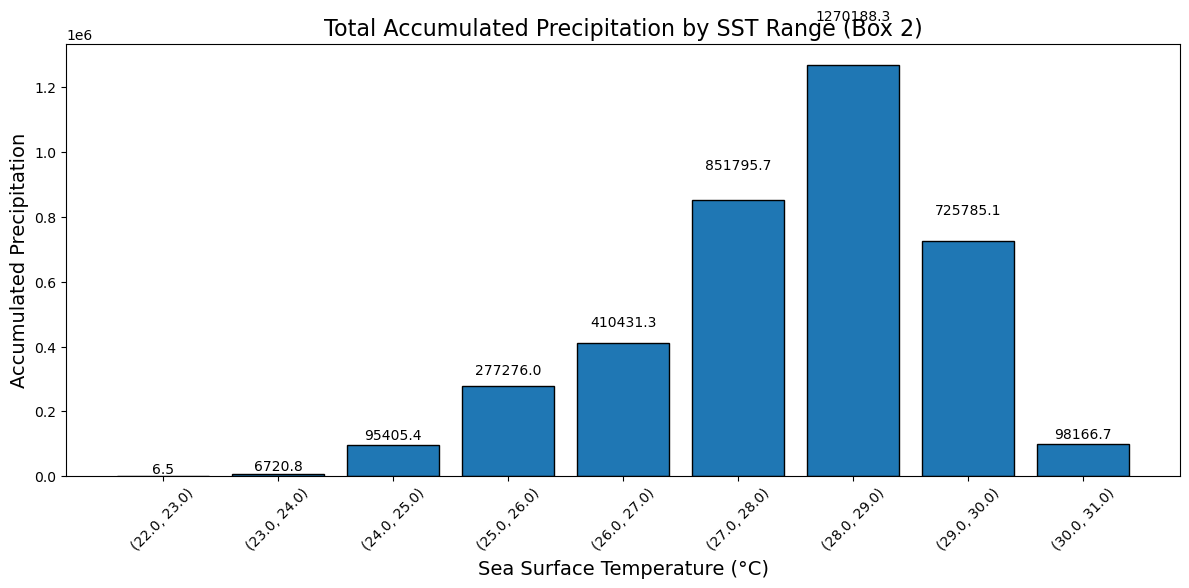

In [370]:
data = pd.DataFrame({'SST': sst_oisst_box_02_values, 'Precipitation': precip_box_02_values})

sst_bins = np.arange(22, 32, 1)
bin_labels = [f'({bin_edge:.1f}, {bin_edge+1:.1f})' for bin_edge in sst_bins[:-1]]


data['SST_bin'] = pd.cut(data['SST'], bins=sst_bins,right = False, labels=bin_labels)

accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()
accumulated_precip['bin_midpoint'] = [bin_edge + 0.5 for bin_edge in range(22, 31)]
print("Accumulated Precipitation by SST Bin:")
print(accumulated_precip)

# Create a bar plot of accumulated precipitation vs SST bins
plt.figure(figsize=(12, 6))
bars = plt.bar(accumulated_precip['bin_midpoint'], accumulated_precip['Precipitation'], 
        width=0.8, edgecolor='black', linewidth=1)

# Add data labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1 * height,
            f'{height:.1f}',
            ha='center', va='bottom', rotation=0, fontsize=10)

plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
plt.ylabel('Accumulated Precipitation', fontsize=14)
plt.title('Total Accumulated Precipitation by SST Range (Box 2)', fontsize=16)
plt.xticks(accumulated_precip['bin_midpoint'], bin_labels, rotation=45)
plt.tight_layout()
plt.show()

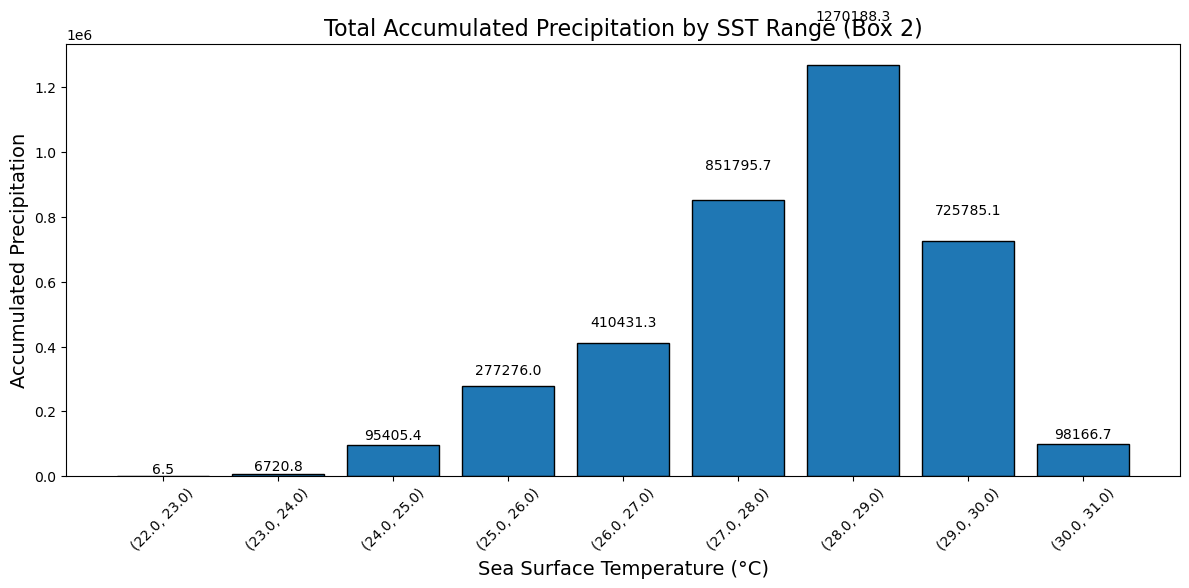

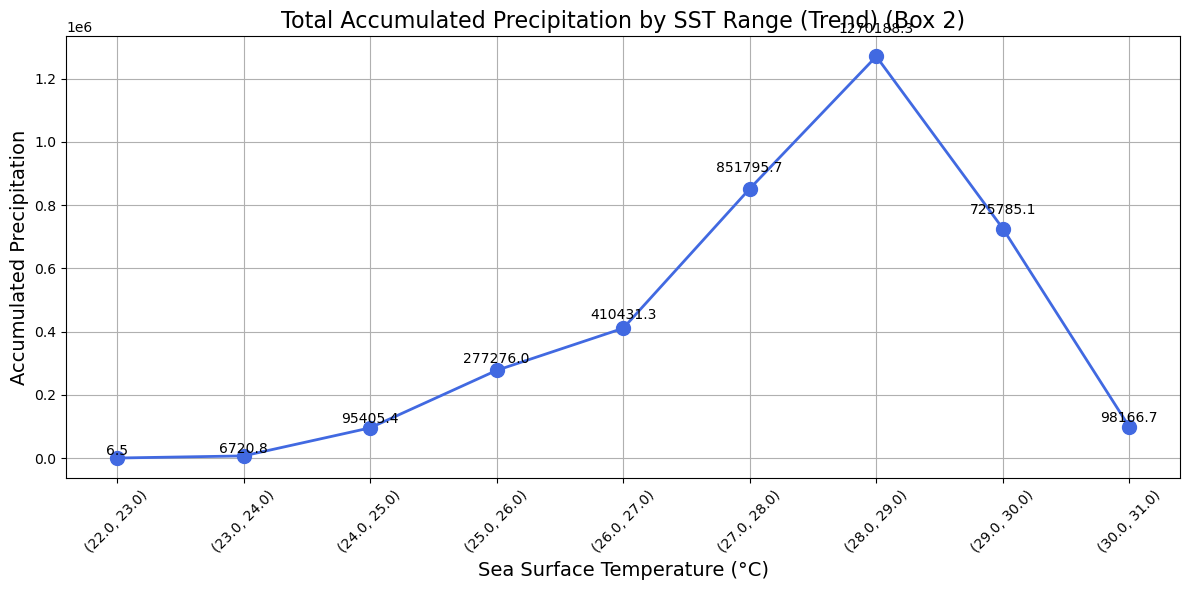


Detailed Statistics for Each SST Bin:
        SST_bin           sum      mean   count         max        std
0  (22.0, 23.0)  6.540000e+00  0.436000      15    1.830000   0.697678
1  (23.0, 24.0)  6.720840e+03  0.682665    9845   88.680000   3.921967
2  (24.0, 25.0)  9.540540e+04  0.865944  110175  282.149994   4.503555
3  (25.0, 26.0)  2.772760e+05  1.272854  217838  385.589996   7.455861
4  (26.0, 27.0)  4.104313e+05  1.906836  215242  422.760010   9.007031
5  (27.0, 28.0)  8.517957e+05  3.645106  233682  290.640015  11.727613
6  (28.0, 29.0)  1.270188e+06  5.253032  241801  443.910004  14.588539
7  (29.0, 30.0)  7.257851e+05  6.362183  114078  438.419952  16.591254
8  (30.0, 31.0)  9.816669e+04  7.159181   13712  289.440002  17.416766


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_48768/2335665066.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_48768/2335665066.py:39: FutureWarning: The provided callable <function std at 0x106f28040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_48768/2335665066.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bi

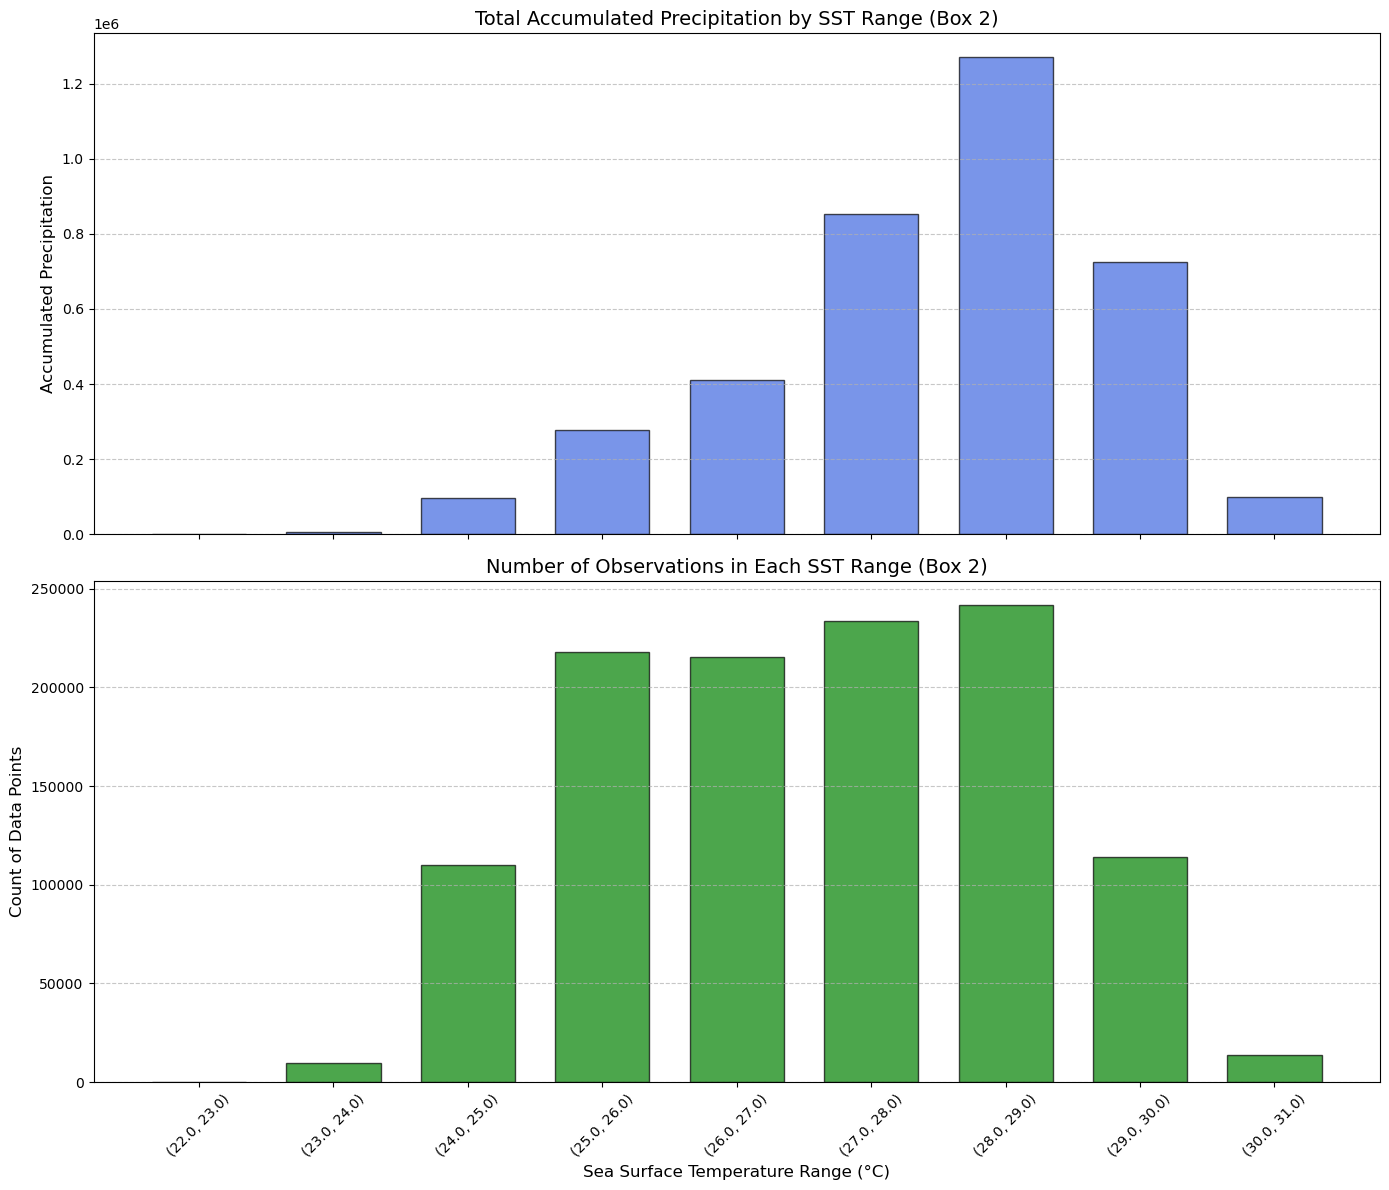

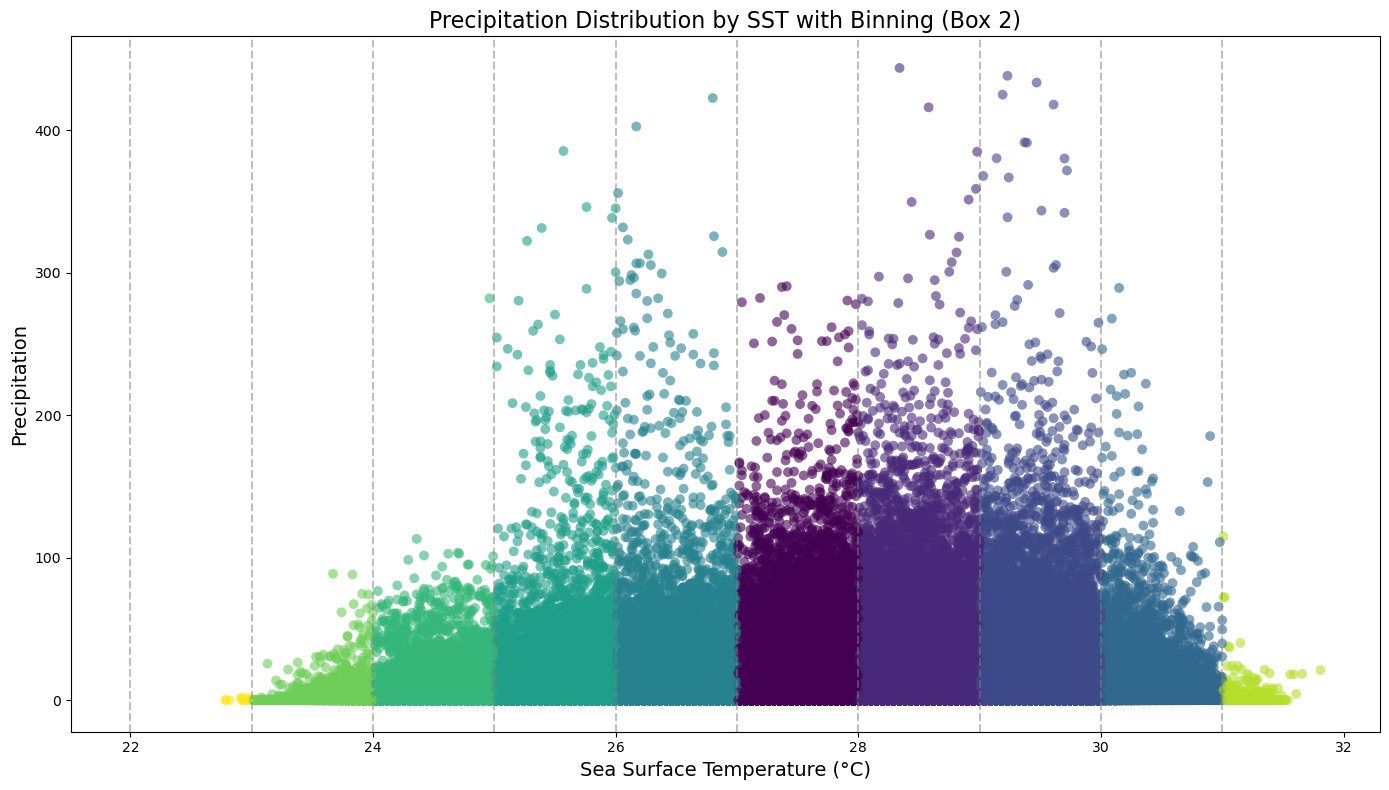

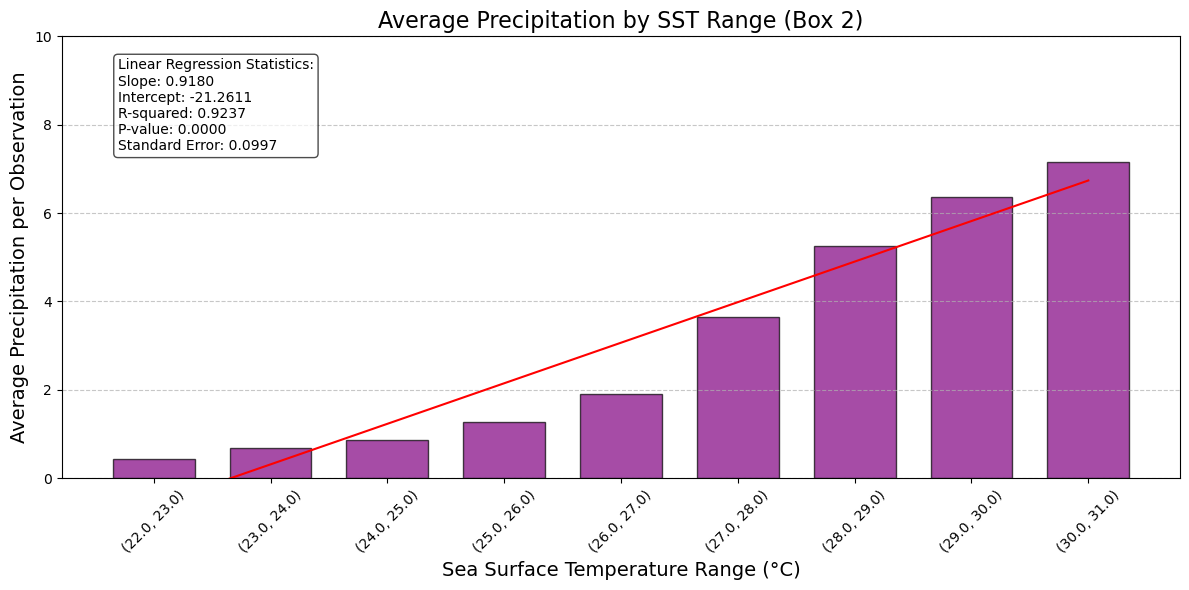

In [371]:
# Create a bar plot of accumulated precipitation vs SST bins
plt.figure(figsize=(12, 6))
bars = plt.bar(accumulated_precip['bin_midpoint'], accumulated_precip['Precipitation'], 
        width=0.8, edgecolor='black', linewidth=1)

# Add data labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1 * height,
            f'{height:.1f}',
            ha='center', va='bottom', rotation=0, fontsize=10)

plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
plt.ylabel('Accumulated Precipitation', fontsize=14)
plt.title('Total Accumulated Precipitation by SST Range (Box 2)', fontsize=16)
plt.xticks(accumulated_precip['bin_midpoint'], bin_labels, rotation=45)
plt.tight_layout()
plt.show()

# Create a line plot to show the trend more clearly
plt.figure(figsize=(12, 6))
plt.plot(accumulated_precip['bin_midpoint'], accumulated_precip['Precipitation'], 
         marker='o', markersize=10, linewidth=2, color='royalblue')

# Add data labels to each point
for i, val in enumerate(accumulated_precip['Precipitation']):
    plt.text(accumulated_precip['bin_midpoint'][i], val + 0.05 * val, 
             f'{val:.1f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
plt.ylabel('Accumulated Precipitation', fontsize=14)
plt.title('Total Accumulated Precipitation by SST Range (Trend) (Box 2)', fontsize=16)
plt.xticks(accumulated_precip['bin_midpoint'], bin_labels, rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Calculate some additional statistics for each bin
bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
    ('sum', 'sum'),              # Total accumulated precipitation
    ('mean', 'mean'),            # Average precipitation per data point in bin
    ('count', 'count'),          # Number of data points in bin
    ('max', 'max'),              # Maximum precipitation in bin
    ('std', np.std)              # Standard deviation of precipitation in bin
]).reset_index()

# Display the detailed statistics
print("\nDetailed Statistics for Each SST Bin:")
print(bin_stats)

# Create a multi-plot figure showing different aspects of the data
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot 1: Accumulated precipitation
axes[0].bar(bin_stats['SST_bin'], bin_stats['sum'], 
          width=0.7, color='royalblue', edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Accumulated Precipitation', fontsize=12)
axes[0].set_title('Total Accumulated Precipitation by SST Range (Box 2)', fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Count of data points in each bin
axes[1].bar(bin_stats['SST_bin'], bin_stats['count'], 
          width=0.7, color='green', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Sea Surface Temperature Range (°C)', fontsize=12)
axes[1].set_ylabel('Count of Data Points', fontsize=12)
axes[1].set_title('Number of Observations in Each SST Range (Box 2)', fontsize=14)
axes[1].set_xticklabels(bin_stats['SST_bin'], rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Create a stacked visualization: Precipitation vs SST with bin coloring
plt.figure(figsize=(14, 8))

# Create a scatter plot with points colored by SST bin
# Convert bin labels to numeric for coloring
unique_bins = data['SST_bin'].unique()
bin_to_number = {bin_label: i for i, bin_label in enumerate(unique_bins)}
data['bin_number'] = data['SST_bin'].map(bin_to_number)

# Scatter plot colored by bin
scatter = plt.scatter(data['SST'], data['Precipitation'], 
                     c=data['bin_number'], cmap='viridis', 
                     alpha=0.6, s=50, edgecolors='none')

# Add vertical lines to show bin boundaries
for bin_edge in sst_bins:
    plt.axvline(x=bin_edge, color='gray', linestyle='--', alpha=0.5)

# Add legend for the bins
legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                    labels=unique_bins,
                    title="SST Bins",
                    loc="upper left",
                    bbox_to_anchor=(1.01, 1))
plt.gca().add_artist(legend1)

plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
plt.ylabel('Precipitation', fontsize=14)
plt.title('Precipitation Distribution by SST with Binning (Box 2)', fontsize=16)
plt.tight_layout()
plt.show()

# Calculate the proportion of total precipitation that falls in each SST bin
total_precip = bin_stats['sum'].sum()
bin_stats['percentage'] = (bin_stats['sum'] / total_precip) * 100


# Normalized precipitation by count (average precipitation per observation in each bin)
plt.figure(figsize=(12, 6))
plt.bar(bin_stats['SST_bin'], bin_stats['mean'], 
       width=0.7, color='purple', edgecolor='black', alpha=0.7)
plt.ylim(0, 10)
plt.xlabel('Sea Surface Temperature Range (°C)', fontsize=14)
plt.ylabel('Average Precipitation per Observation', fontsize=14)
plt.title('Average Precipitation by SST Range (Box 2)', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

slope, intercept, r_value, p_value, std_err = stats.linregress(accumulated_precip['bin_midpoint'], bin_stats['mean'])

regression_line = slope * accumulated_precip['bin_midpoint'] + intercept 
plt.plot(bin_stats['SST_bin'], regression_line, color='red', label='Linear Regression')
stats_text = (f'Linear Regression Statistics:\n'
              f'Slope: {slope:.4f}\n'
              f'Intercept: {intercept:.4f}\n'
              f'R-squared: {r_value**2:.4f}\n'
              f'P-value: {p_value:.4f}\n'
              f'Standard Error: {std_err:.4f}')

plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.show()

## Box 3

In [372]:
precip_box_03 = precip.sel(lat=slice(-18,-15), lon=slice(157,160))

precip_box_03_rain = np.where(precip_box_03 > 0.01, precip_box_03, np.nan)

sst_oisst_box_03 = sst_oisst.sel(lat=slice(-18,-15), lon=slice(157,160))

In [373]:
precip_box_03_values = precip_box_03.values.reshape(8034*12*12)

precip_box_03_values_log = np.log1p(precip_box_03_values)

sst_oisst_box_03_values = sst_oisst_box_03.values.reshape(8034*12*12)

precip_box_03_values_rain = precip_box_03_rain.reshape(8034*12*12)

In [374]:
data = pd.DataFrame({'SST': sst_oisst_box_03_values, 'Precipitation': precip_box_03_values})

sst_bins = np.arange(22, 32, 1)
bin_labels = [f'({bin_edge:.1f}, {bin_edge+1:.1f})' for bin_edge in sst_bins[:-1]]


data['SST_bin'] = pd.cut(data['SST'], bins=sst_bins,right = False, labels=bin_labels)

accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()
accumulated_precip['bin_midpoint'] = [bin_edge + 0.5 for bin_edge in range(22, 31)]
print("Accumulated Precipitation by SST Bin:")
print(accumulated_precip)


Accumulated Precipitation by SST Bin:
        SST_bin  Precipitation  bin_midpoint
0  (22.0, 23.0)   4.440000e+00          22.5
1  (23.0, 24.0)   1.263783e+04          23.5
2  (24.0, 25.0)   2.288706e+05          24.5
3  (25.0, 26.0)   8.168816e+05          25.5
4  (26.0, 27.0)   1.188476e+06          26.5
5  (27.0, 28.0)   1.512880e+06          27.5
6  (28.0, 29.0)   1.948683e+06          28.5
7  (29.0, 30.0)   1.052667e+06          29.5
8  (30.0, 31.0)   7.962405e+04          30.5


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_48768/1369341610.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()


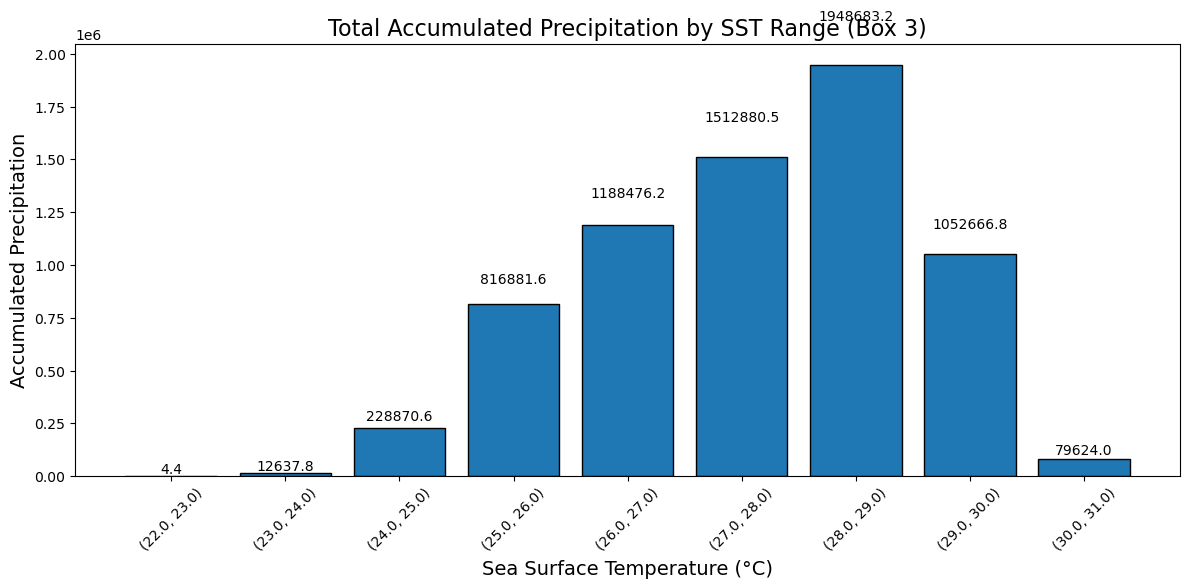

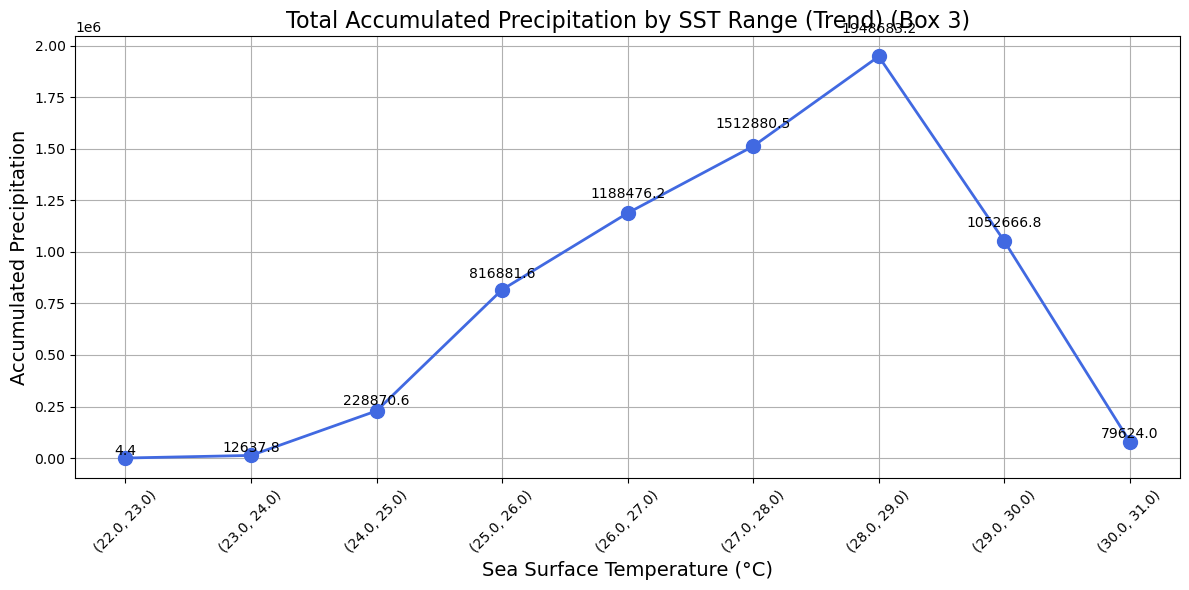

/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_48768/2736275881.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_48768/2736275881.py:39: FutureWarning: The provided callable <function std at 0x106f28040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_48768/2736275881.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bi


Detailed Statistics for Each SST Bin:
        SST_bin           sum      mean   count         max        std
0  (22.0, 23.0)  4.440000e+00  1.110000       4    1.200000   0.064807
1  (23.0, 24.0)  1.263783e+04  2.651108    4767   79.079994   6.737558
2  (24.0, 25.0)  2.288706e+05  2.779951   82329  266.910004   8.565446
3  (25.0, 26.0)  8.168816e+05  4.251801  192126  311.849976  11.846887
4  (26.0, 27.0)  1.188476e+06  5.046286  235515  282.179993  12.864798
5  (27.0, 28.0)  1.512880e+06  6.327608  239092  271.889984  15.106885
6  (28.0, 29.0)  1.948683e+06  7.337573  265576  309.089996  15.689375
7  (29.0, 30.0)  1.052667e+06  8.167932  128878  343.559998  15.865494
8  (30.0, 31.0)  7.962405e+04  9.293190    8568  147.330002  16.290828


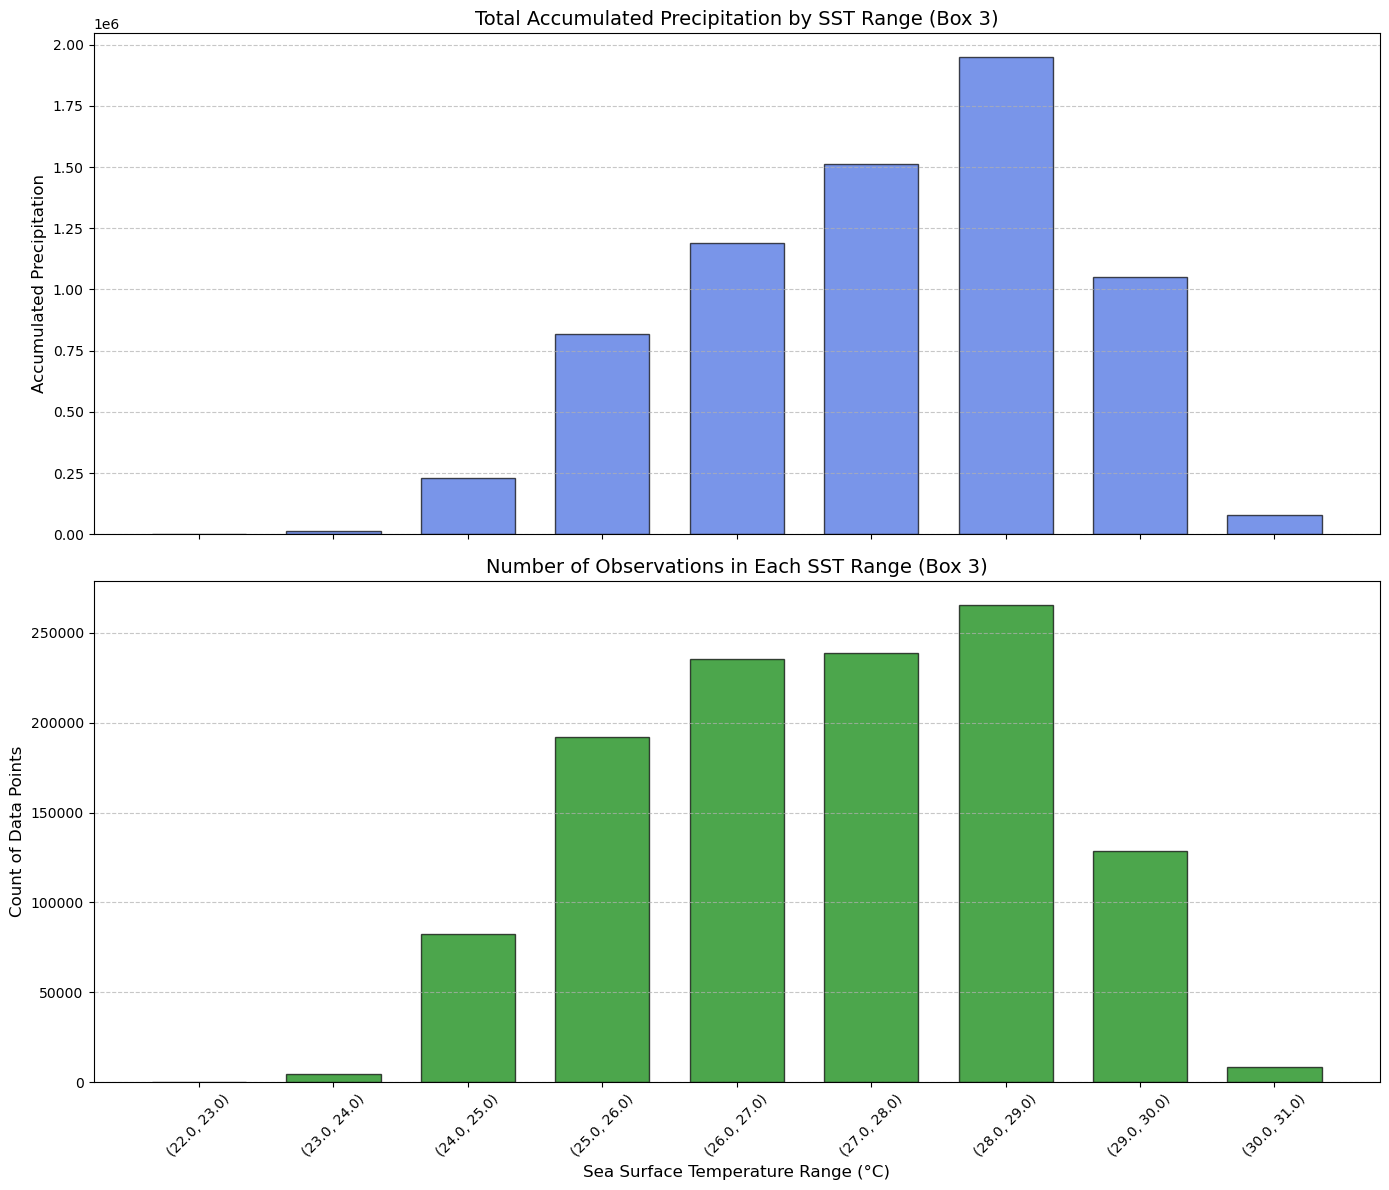

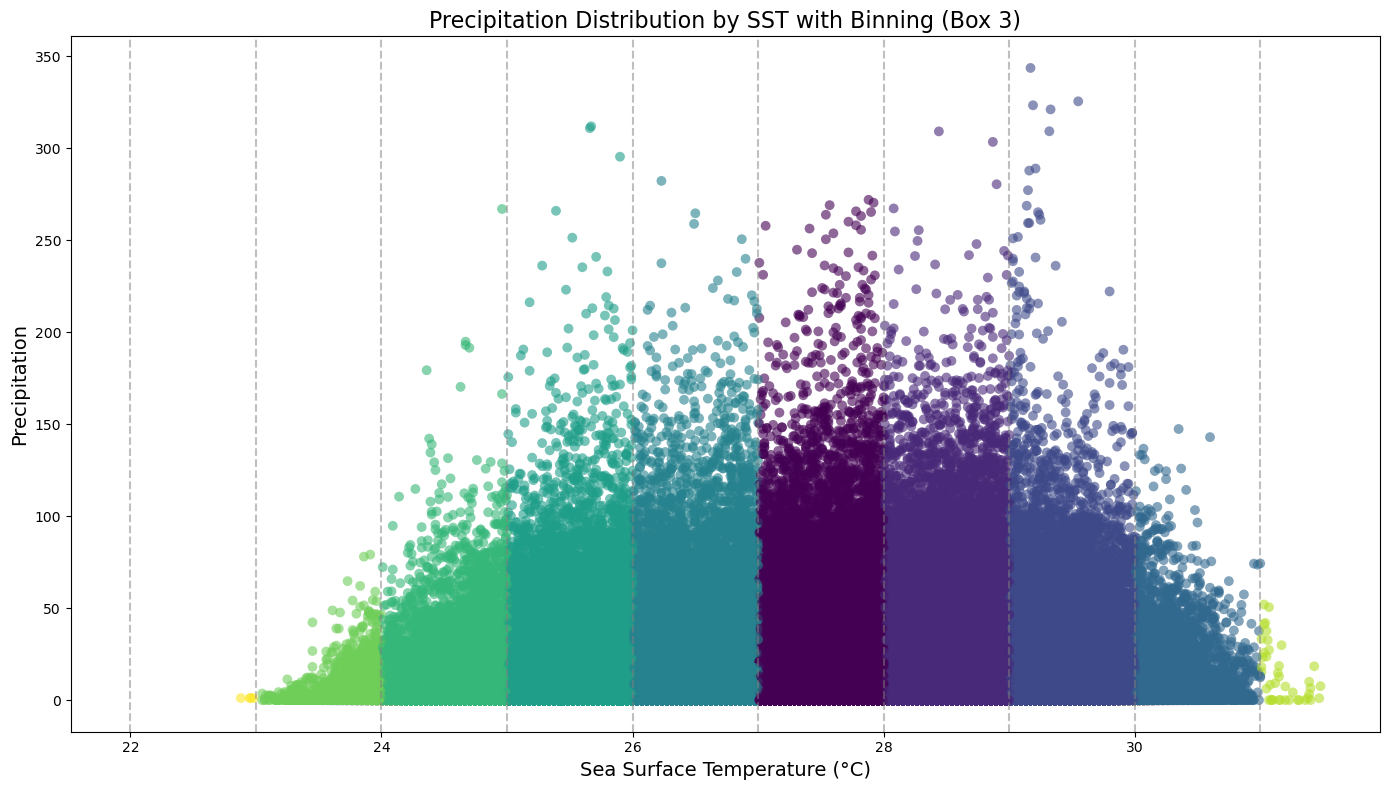

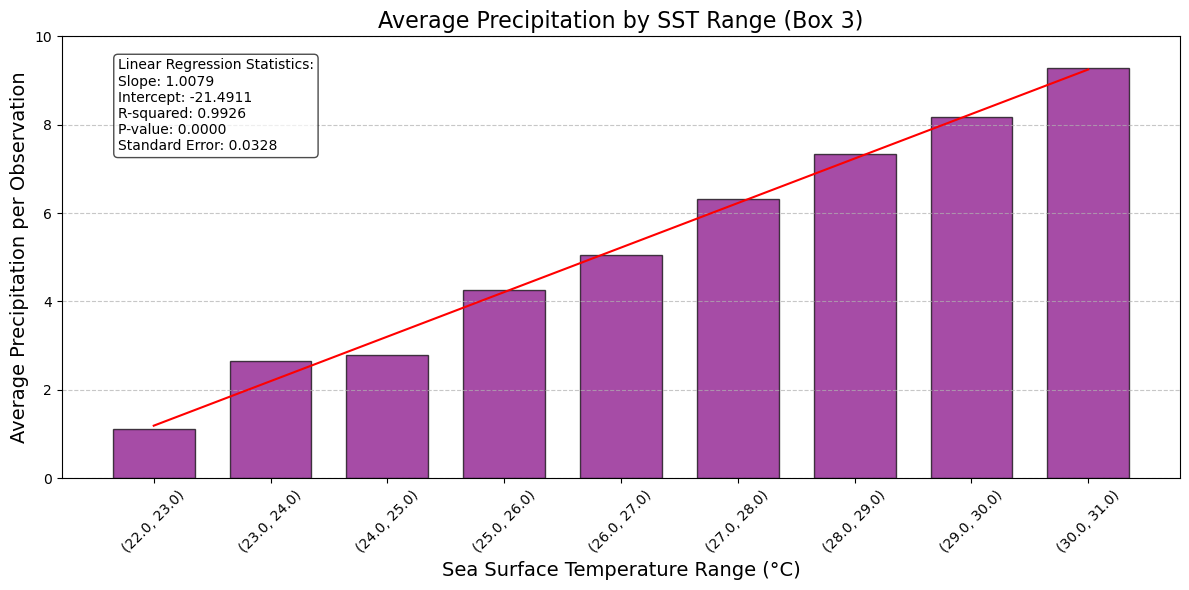

In [375]:
# Create a bar plot of accumulated precipitation vs SST bins
plt.figure(figsize=(12, 6))
bars = plt.bar(accumulated_precip['bin_midpoint'], accumulated_precip['Precipitation'], 
        width=0.8, edgecolor='black', linewidth=1)

# Add data labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1 * height,
            f'{height:.1f}',
            ha='center', va='bottom', rotation=0, fontsize=10)

plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
plt.ylabel('Accumulated Precipitation', fontsize=14)
plt.title('Total Accumulated Precipitation by SST Range (Box 3)', fontsize=16)
plt.xticks(accumulated_precip['bin_midpoint'], bin_labels, rotation=45)
plt.tight_layout()
plt.show()

# Create a line plot to show the trend more clearly
plt.figure(figsize=(12, 6))
plt.plot(accumulated_precip['bin_midpoint'], accumulated_precip['Precipitation'], 
         marker='o', markersize=10, linewidth=2, color='royalblue')

# Add data labels to each point
for i, val in enumerate(accumulated_precip['Precipitation']):
    plt.text(accumulated_precip['bin_midpoint'][i], val + 0.05 * val, 
             f'{val:.1f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
plt.ylabel('Accumulated Precipitation', fontsize=14)
plt.title('Total Accumulated Precipitation by SST Range (Trend) (Box 3)', fontsize=16)
plt.xticks(accumulated_precip['bin_midpoint'], bin_labels, rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Calculate some additional statistics for each bin
bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
    ('sum', 'sum'),              # Total accumulated precipitation
    ('mean', 'mean'),            # Average precipitation per data point in bin
    ('count', 'count'),          # Number of data points in bin
    ('max', 'max'),              # Maximum precipitation in bin
    ('std', np.std)              # Standard deviation of precipitation in bin
]).reset_index()

# Display the detailed statistics
print("\nDetailed Statistics for Each SST Bin:")
print(bin_stats)

# Create a multi-plot figure showing different aspects of the data
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot 1: Accumulated precipitation
axes[0].bar(bin_stats['SST_bin'], bin_stats['sum'], 
          width=0.7, color='royalblue', edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Accumulated Precipitation', fontsize=12)
axes[0].set_title('Total Accumulated Precipitation by SST Range (Box 3)', fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Count of data points in each bin
axes[1].bar(bin_stats['SST_bin'], bin_stats['count'], 
          width=0.7, color='green', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Sea Surface Temperature Range (°C)', fontsize=12)
axes[1].set_ylabel('Count of Data Points', fontsize=12)
axes[1].set_title('Number of Observations in Each SST Range (Box 3)', fontsize=14)
axes[1].set_xticklabels(bin_stats['SST_bin'], rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Create a stacked visualization: Precipitation vs SST with bin coloring
plt.figure(figsize=(14, 8))

# Create a scatter plot with points colored by SST bin
# Convert bin labels to numeric for coloring
unique_bins = data['SST_bin'].unique()
bin_to_number = {bin_label: i for i, bin_label in enumerate(unique_bins)}
data['bin_number'] = data['SST_bin'].map(bin_to_number)

# Scatter plot colored by bin
scatter = plt.scatter(data['SST'], data['Precipitation'], 
                     c=data['bin_number'], cmap='viridis', 
                     alpha=0.6, s=50, edgecolors='none')

# Add vertical lines to show bin boundaries
for bin_edge in sst_bins:
    plt.axvline(x=bin_edge, color='gray', linestyle='--', alpha=0.5)

# Add legend for the bins
legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                    labels=unique_bins,
                    title="SST Bins",
                    loc="upper left",
                    bbox_to_anchor=(1.01, 1))
plt.gca().add_artist(legend1)

plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
plt.ylabel('Precipitation', fontsize=14)
plt.title('Precipitation Distribution by SST with Binning (Box 3)', fontsize=16)
plt.tight_layout()
plt.show()

# Calculate the proportion of total precipitation that falls in each SST bin
total_precip = bin_stats['sum'].sum()
bin_stats['percentage'] = (bin_stats['sum'] / total_precip) * 100


# Normalized precipitation by count (average precipitation per observation in each bin)
plt.figure(figsize=(12, 6))
plt.bar(bin_stats['SST_bin'], bin_stats['mean'], 
       width=0.7, color='purple', edgecolor='black', alpha=0.7)
plt.ylim(0, 10)
plt.xlabel('Sea Surface Temperature Range (°C)', fontsize=14)
plt.ylabel('Average Precipitation per Observation', fontsize=14)
plt.title('Average Precipitation by SST Range (Box 3)', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

slope, intercept, r_value, p_value, std_err = stats.linregress(accumulated_precip['bin_midpoint'], bin_stats['mean'])

regression_line = slope * accumulated_precip['bin_midpoint'] + intercept 
plt.plot(bin_stats['SST_bin'], regression_line, color='red', label='Linear Regression')
stats_text = (f'Linear Regression Statistics:\n'
              f'Slope: {slope:.4f}\n'
              f'Intercept: {intercept:.4f}\n'
              f'R-squared: {r_value**2:.4f}\n'
              f'P-value: {p_value:.4f}\n'
              f'Standard Error: {std_err:.4f}')

plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.show()